# **Library Imports**

In [ ]:
# -*- coding: utf-8 -*-
"""Cleaned dispenser solution"""
try:
    from dlroms import *
except:
    !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
    from dlroms import *

from google.colab import files, drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/MOR_data')
if not os.path.exists("dispenser.py"):
    print("dispenser.py not found in the current directory. Please upload the file.")
    uploaded = files.upload()

from dispenser import FOMsolver, Vh, Vb, stokes_solver, bottomOutflow, num2p
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt
from fenics import inner, grad, dx, ds, FacetNormal
from scipy.sparse.linalg import spsolve
from time import perf_counter
import random

# **Task i)**

to show the PDE can be reformulated into the homogeneous problem
The evolution of the chemical concentration $u$ is governed by:

$$
\begin{align*}
\text{PDE:}& \quad \frac{\partial u}{\partial t} - \frac{1}{2}\Delta u + \mathbf{b} \cdot \nabla u = 0 && \text{in } \Omega \times (0,T) \\
\text{Boundary Conditions:}& \quad u = 1 && \text{on } \Gamma^{\text{in}} \times (0,T) \quad \text{(Dirichlet)} \\
& \quad \nabla u \cdot \mathbf{n} = 0 && \text{on } (\partial \Omega \setminus \Gamma^{\text{in}}) \times (0,T) \quad \text{(Neumann)} \\
\text{Initial Condition:}& \quad u(\cdot, 0) = 1_{\Gamma^{\text{in}}} && \text{in } \Omega
\end{align*}
$$

------------------------
We introduce the change of variables $u = u_{\text{hom}} + 1$. Let's find the corresponding terms for the PDE:

$$
\begin{align*}
\text{Time derivative:}& \quad \frac{\partial u}{\partial t} &= \frac{\partial(u_{\text{hom}} + 1)}{\partial t} = \frac{\partial u_{\text{hom}}}{\partial t} \\
\text{Gradient:}& \quad \nabla u &= \nabla(u_{\text{hom}} + 1) = \nabla u_{\text{hom}} \\
\text{Laplacian:}& \quad \Delta u &= \Delta(u_{\text{hom}} + 1) = \Delta u_{\text{hom}}
\end{align*}
$$

------------------------
Substituting these into the PDE gives:

$$
\frac{\partial u_{\text{hom}}}{\partial t} - \frac{1}{2}\Delta u_{\text{hom}} + \mathbf{b} \cdot \nabla u_{\text{hom}} = 0
$$

-------------------------
We now apply the transformation $u = u_{\text{hom}} + 1$ to the auxiliary conditions:

$$
\begin{align*}
\text{Dirichlet BC:}& \quad u = 1 && \text{on } \Gamma^{\text{in}} \\
& \quad u_{\text{hom}} + 1 = 1 \implies u_{\text{hom}} = 0 && \text{on } \Gamma^{\text{in}} \\[1em]
\text{Neumann BC:}& \quad \nabla u \cdot \mathbf{n} = 0 && \text{on } (\partial \Omega \setminus \Gamma^{\text{in}}) \\
& \quad \nabla u_{\text{hom}} \cdot \mathbf{n} = 0 && \text{on } (\partial \Omega \setminus \Gamma^{\text{in}}) \\[1em]
\text{Initial Condition:}& \quad u(\cdot, 0) = 1_{\Gamma^{\text{in}}} && \text{in } \Omega \\
& \quad u_{\text{hom}}(\cdot, 0) + 1 = 1_{\Gamma^{\text{in}}} \implies u_{\text{hom}}(\cdot, 0) = 1_{\Gamma^{\text{in}}} - 1
\end{align*}
$$

-----------------

The velocity field $\mathbf{b}$ is the solution to the Stokes' equation (Equation 1), which is a linear problem. The flow is driven by the inflow boundary conditions, which are linear in the parameters $c_1, c_2, c_3$.

By the principle of superposition for linear systems, the solution $\mathbf{b}$ can be expressed as a linear combination of basis solutions. Let:
*   $\mathbf{b}_1$ be the solution to Stokes' equation for $(c_1, c_2, c_3) = (1, 0, 0)$.
*   $\mathbf{b}_2$ be the solution to Stokes' equation for $(c_1, c_2, c_3) = (0, 1, 0)$.
*   $\mathbf{b}_3$ be the solution to Stokes' equation for $(c_1, c_2, c_3) = (0, 0, 1)$.

Then, the general solution for an arbitrary set of parameters $(c_1, c_2, c_3)$ is:
$$
\mathbf{b} = c_1\mathbf{b}_1 + c_2\mathbf{b}_2 + c_3\mathbf{b}_3
$$

Substituting this affine expansion of $\mathbf{b}$ into our transformed PDE, we get:
$$
\frac{\partial u_{\text{hom}}}{\partial t} - \frac{1}{2}\Delta u_{\text{hom}} + (c_1\mathbf{b}_1 + c_2\mathbf{b}_2 + c_3\mathbf{b}_3) \cdot \nabla u_{\text{hom}} = 0
$$

**importance of homogeneous transformation**:
not having the u = 0 boundary condition means that u_hom(t) ≈ V * c(t) must somehow equal 1 at the inlet. This means the evolving coefficients c(t) must satisfy a complex linear constraint at every single time step

while in case of homogeneous
At any time t, our approximation V * c(t) is guaranteed to be zero at the inlet because every column of V is zero there(Since every u_hom snapshot is zero at the inlet, the basis functions in V are also zero at the inlet). It automatically and effortlessly satisfies the homogeneous boundary condition for all time.

# **Part 1: Data Generation & Preprocessing (Task ii)**

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
# Seed for reproducibility
np.random.seed(42)
random.seed(42)

# Data handling
mu_path, u_path = "mu.npy", "u.npy"
if os.path.isfile(mu_path) and os.path.isfile(u_path):
    print("Loading precomputed data...")
    mu, u = np.load(mu_path), np.load(u_path)
else:
    print("Generating new data...")
    epoch = 20
    mu_list, u_list = [], []

    # Parameter generation
    z = []
    for _ in range(epoch):
        num1 = random.uniform(0, 50)
        num2 = random.uniform(0, 50)
        num3 = random.uniform(0, 50)
        z.append([num1, num2, num3])

    z = np.array(z).reshape(-1, 3)
    # FOM simulations
    for i in range(epoch):
        muj = z[i, :]
        uj = FOMsolver(muj[0], muj[1], muj[2], steps=700, dt=5e-4)
        u_list.append(uj - 1) # Apply transformation u_hom = u - 1 to handle non-homogeneous BCs
        mu_list.append(muj)

    u = np.stack(u_list)
    mu = np.stack(mu_list)
    np.save('u.npy', u)
    np.save('mu.npy', mu)

u_base = u
mu_base = mu


Loading precomputed data...


In [ ]:
mu

array([[4.33088073e+01, 5.92414569e-01, 6.01115012e-01],
       [1.45614570e+01, 6.97469303e+00, 7.31993942e-01],
       [7.31993942e-01, 1.99673782e-01, 1.99673782e-01],
       [6.50515930e-02, 2.05844943e-02, 4.31945019e-01],
       [3.54036289e+01, 6.01115012e-01, 4.75357153e+01],
       [2.32252064e+00, 9.17022549e+00, 2.99329242e+01],
       [3.92587981e+01, 1.81824967e-01, 8.52620618e+00],
       [3.92587981e+01, 6.84233027e-01, 1.56018640e-01],
       [2.32252064e+00, 2.99329242e+01, 6.84233027e-01],
       [1.45614570e+01, 1.06169555e+01, 3.54036289e+01],
       [4.56069984e-01, 8.52620618e+00, 8.52620618e+00],
       [4.88360570e+00, 1.81824967e-01, 4.74442769e+01],
       [6.01115012e-01, 6.97469303e+00, 6.50515930e-02],
       [3.92587981e+01, 3.04613769e-01, 5.92414569e-01],
       [7.31993942e-01, 8.52620618e+00, 4.33088073e+01],
       [8.32442641e-01, 9.65632033e-01, 2.92144649e-01],
       [3.04613769e-01, 4.56069984e-01, 2.20076247e+01],
       [6.84233027e-01, 1.99673

# **Part 2: POD Analysis & Basis Selection (Task ii)**

FOM dimension: 1940
Trajectories: 20, Time-steps: 701
ntrain: 10
u shape: (20, 701, 1940)
Utrain shape: (1940, 7010)
X: (1940, 1940)
S: (1940,)


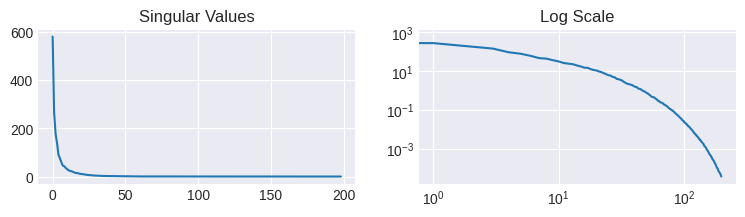

Number of POD modes: 113
Average projection error: 0.66%


In [ ]:
print(f"FOM dimension: {u.shape[-1]}")
print(f"Trajectories: {mu.shape[0]}, Time-steps: {u.shape[1]}")

# POD analysis

ntrain = u.shape[0] // 2
Utrain = u[:ntrain, :, :].reshape(-1, Vh.dim()).T # (N. traj(train) x N. steps) x N. elements
X, s, _ = svd(Utrain, full_matrices=False) # transpose so the U, S, V make sense

# The snapshot matrix Utrain was constructed by reshaping the data
# into a 2D matrix of shape (N_dof, N_snapshots), for SVD.

print(f"ntrain: {ntrain}")
print(f"u shape: {u.shape}") # N. traj x N. steps x N. elements
print(f"Utrain shape: {Utrain.shape}") # N. elements x (N. traj(train) x N. steps)
print(f"X: {X.shape}") # N. elements x N. elements
print(f"S: {s.shape}") # N. elements
# Plot singular values
plt.figure(figsize=(9, 2))
plt.subplot(121), plt.plot(s[1:200]), plt.title("Singular Values")
plt.subplot(122), plt.loglog(s[1:200]), plt.title("Log Scale")

plt.savefig("Plot singular values.png",dpi=600,bbox_inches="tight")  # Saves as PNG
plt.show()

# Determine basis size
energy = np.cumsum(s**2) / np.sum(s**2)
r = np.argmax(energy >= 0.9999999999) + 1 # this outputs 113 basis functions
print(f"Number of POD modes: {r}")

V = X[:, :r]

# Projection error analysis
Utest = u[ntrain:].reshape(-1, Vh.dim()).T
Uproj = V @ (V.T @ Utest)
errors = np.linalg.norm(Utest - Uproj, axis = 0) / np.linalg.norm(Utest, axis = 0)
ntest = u.shape[0] - ntrain
errors = errors.reshape(ntest, u.shape[1])
print(f"Average projection error: {num2p(errors.max(axis=1).mean())}")


Interpretation of the Results:

"" Singular Value Plot: The singular values decay very rapidly. This is the ideal scenario for model order reduction. It means that the system's dynamics are dominated by a small number of coherent structures, and the data is highly "compressible." A low-dimensional basis should be able to capture the system's behavior very accurately. ""

using projection error to find r:
$$E_{\text{proj}}=\frac{1}{N_{\text{test}}}\sum_{i=1}^{N_\text{test}}\frac{|\mathbf{u}_{i}^{\text{test}}-\mathbf{V}\mathbf{V}^{\top}\mathbf{u}_{i}^{\text{test}}|}{|\mathbf{u}_{i}^{\text{test}}|}$$

In [ ]:
Utest = u[ntrain:].reshape(-1, Vh.dim()).T
ntest = u.shape[0] - ntrain
errorList = []

# in this loop the projection error was stored to analyze the decay
for r in range(1, 200):
  V = X[:, :r]

  # Projection error analysis

  Uproj = V @ (V.T @ Utest)
  errors = np.linalg.norm(Utest - Uproj, axis = 0) / np.linalg.norm(Utest, axis = 0)

  errors = errors.reshape(ntest, u.shape[1])
  errorList.append(errors.max(axis=1).mean())
  # print(f"Average projection error: {num2p(errors.max(axis=1).mean())}")

In [ ]:
# use a pre-specified average error and choose r based on that
AvgErr = 0.66 #percent
errorArray = np.array(errorList)
indices = np.where(errorArray < AvgErr/100 )[0]
r = indices[0]
V = X[:, :r]

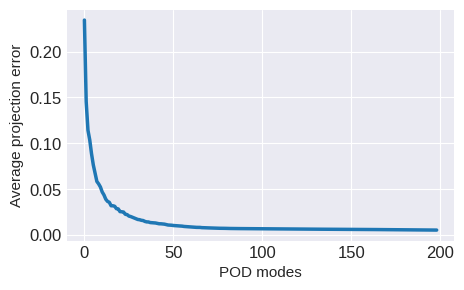

([<matplotlib.lines.Line2D at 0x7e1f7c0a5910>], Text(0.5, 1.0, 'Log Scale'))

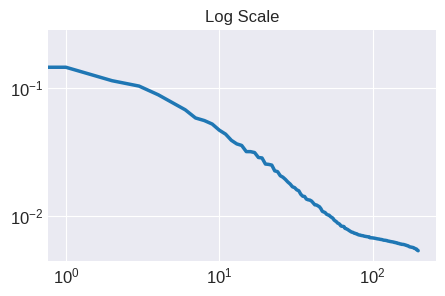

In [ ]:
# or look at the decay and decide the r
plt.figure(figsize=(5, 3))
plt.plot(errorList)
plt.xlabel("POD modes")
plt.ylabel("Average projection error")
plt.show()

plt.figure(figsize=(5, 3))
plt.loglog(errorList), plt.title("Log Scale")

we can see from the projection error that decay rate slows down at 50 60 bais function we can choose r = 90

In [ ]:
r = 90
V = X[:, :r]

### ***side note***: looking at how the basis functions look like

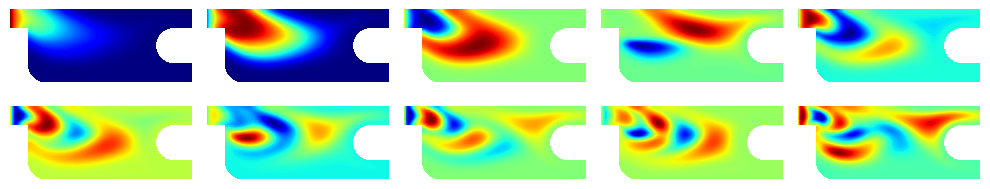

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(10):
  V0 = fe.asfunction(V[:,i],Vh)
  plt.subplot(5,5,i+1)
  fe.plot(V0)

plt.tight_layout()
plt.show()

# **Part 3: ROM Implementation and Performance (Task iii)**

## **Offline Stage**

Let's start with PDE for $u_{\text{hom}}$ (after applying the transformation):
$$
\frac{\partial u_{\text{hom}}}{\partial t} - \frac{1}{2}\Delta u_{\text{hom}} + (c_1\mathbf{b}_1 + c_2\mathbf{b}_2 + c_3\mathbf{b}_3) \cdot \nabla u_{\text{hom}} = 0
$$

After discretization with Finite Elements and applying a time-stepping scheme (Backward Euler), this PDE becomes a system of algebraic equations at each time step $n+1$:
$$
\frac{\mathbf{u}_{\text{hom}}^{n+1} - \mathbf{u}_{\text{hom}}^n}{\Delta t} - \frac{1}{2}\Delta_h \mathbf{u}_{\text{hom}}^{n+1} + (c_1\mathbf{b}_1 + c_2\mathbf{b}_2 + c_3\mathbf{b}_3) \cdot \nabla_h \mathbf{u}_{\text{hom}}^{n+1} = 0
$$

Now, let's represent the discrete operators with matrices:
*   **M**: The mass matrix, from the $\frac{\partial u_{\text{hom}}}{\partial t}$ term.
*   **S**: The stiffness matrix, from the $-\frac{1}{2}\Delta u_{\text{hom}}$ term.
*   **B(μ)**: The advection/convection matrix, from the $(c_1\mathbf{b}_1 + \dots) \cdot \nabla u_{\text{hom}}$ term. This is the only matrix that depends on the parameters $\mu = [c_1, c_2, c_3]$.

Rearranging the equation to solve for $\mathbf{u}_{\text{hom}}^{n+1}$:
$$
\begin{align*}
\frac{\mathbf{M}}{\Delta t} \mathbf{u}_{\text{hom}}^{n+1} + \mathbf{S} \mathbf{u}_{\text{hom}}^{n+1} + \mathbf{B}(\mu) \mathbf{u}_{\text{hom}}^{n+1} &= \frac{\mathbf{M}}{\Delta t} \mathbf{u}_{\text{hom}}^n \\[1em]
\text{Multiplying by } \Delta t: \quad \mathbf{M} \mathbf{u}_{\text{hom}}^{n+1} + \Delta t\mathbf{S} \mathbf{u}_{\text{hom}}^{n+1} + \Delta t\mathbf{B}(\mu) \mathbf{u}_{\text{hom}}^{n+1} &= \mathbf{M} \mathbf{u}_{\text{hom}}^n \\[1em]
\text{Factoring out } \mathbf{u}_{\text{hom}}^{n+1}: \quad (\mathbf{M} + \Delta t\mathbf{S} + \Delta t\mathbf{B}(\mu)) \mathbf{u}_{\text{hom}}^{n+1} &= \mathbf{M} \mathbf{u}_{\text{hom}}^n
\end{align*}
$$

Now we apply the ROM framework.

Approximate the solution:
$$
\mathbf{u}_{\text{hom}} \approx \mathbf{V} \mathbf{c}_{\text{rb}}
\quad (\text{where } \mathbf{c}_{\text{rb}} \text{ are the reduced coordinates})
$$

We substitute this into the full-order system and project onto the test basis (Galerkin projection, $\mathbf{V}^{\text{T}}$):
$$
\begin{align*}
\text{Substitute:} \quad (\mathbf{M} + \Delta t\mathbf{S} + \Delta t\mathbf{B}(\mu)) \mathbf{V} \mathbf{c}_{\text{rb}}^{n+1} &= \mathbf{M} \mathbf{V} \mathbf{c}_{\text{rb}}^n \\[1.5em]
\text{Project:} \quad \mathbf{V}^{\text{T}} (\mathbf{M} + \Delta t\mathbf{S} + \Delta t\mathbf{B}(\mu)) \mathbf{V} \mathbf{c}_{\text{rb}}^{n+1} &= \mathbf{V}^{\text{T}} \mathbf{M} \mathbf{V} \mathbf{c}_{\text{rb}}^n \\[1.5em]
\text{Distribute:} \quad (\mathbf{V}^{\text{T}}\mathbf{M}\mathbf{V} + \Delta t\mathbf{V}^{\text{T}}\mathbf{S}\mathbf{V} + \Delta t\mathbf{V}^{\text{T}}\mathbf{B}(\mu)\mathbf{V}) \mathbf{c}_{\text{rb}}^{n+1} &= (\mathbf{V}^{\text{T}}\mathbf{M}\mathbf{V}) \mathbf{c}_{\text{rb}}^n \\[1.5em]
\text{Substitute reduced matrices:} \quad (\mathbf{M}_{\text{rb}} + \Delta t\mathbf{S}_{\text{rb}} + \Delta t(c_1\mathbf{B}_{\text{rb1}} + c_2\mathbf{B}_{\text{rb2}} + c_3\mathbf{B}_{\text{rb3}})) \mathbf{c}_{\text{rb}}^{n+1} &= \mathbf{M}_{\text{rb}} \mathbf{c}_{\text{rb}}^n
\end{align*}
$$

Let $\mathbf{B}_{\text{rb}} = c_1\mathbf{B}_{\text{rb1}} + c_2\mathbf{B}_{\text{rb2}} + c_3\mathbf{B}_{\text{rb3}}$. The final reduced system is:
$$
(\mathbf{M}_{\text{rb}} + \Delta t\mathbf{S}_{\text{rb}} + \Delta t\mathbf{B}_{\text{rb}}) \mathbf{c}_{\text{rb}}^{n+1} = \mathbf{M}_{\text{rb}} \mathbf{c}_{\text{rb}}^n
$$
then:
$$
\mathbf{u}_{\text{hom}} \approx \mathbf{V} \mathbf{c}_{\text{rb}}
$$
$$
\mathbf{u} = \mathbf{u}_{\text{hom}} + 1
$$

### Derivation of the Mass Matrix (M)

The mass matrix arises from the time derivative term $\frac{\partial u_h}{\partial t}$ in the PDE. The corresponding term in the weak form is obtained by multiplying by a test function $v$ and integrating over the domain $\Omega$:

$$
\int_{\Omega} \frac{\partial u_h}{\partial t} v \, dx
$$

We discretize the solution $u_h$ using $N_h$ finite element basis functions $\phi_j(x)$ and unknown, time-dependent coefficients $u_j(t)$:
$$
u_h(x, t) = \sum_{j=1}^{N_h} u_j(t) \phi_j(x)
$$
We test against each basis function $v = \phi_i(x)$ for $i=1, \dots, N_h$. Substituting these into the integral gives the $i$-th row of the system:
$$
\int_{\Omega} \left( \frac{\partial}{\partial t} \sum_{j=1}^{N_h} u_j(t) \phi_j(x) \right) \phi_i(x) \, dx = \sum_{j=1}^{N_h} \frac{du_j(t)}{dt} \int_{\Omega} \phi_j(x) \phi_i(x) \, dx
$$
This is the $i$-th component of the matrix-vector product $\mathbf{M} \frac{d\mathbf{u}_h}{dt}$. The entries of the mass matrix $\mathbf{M}$ are therefore defined as:
$$
\mathbf{M}_{ij} = \int_{\Omega} \phi_j(x) \phi_i(x) \, dx
$$
This corresponds to the FEniCS code:

M = fe.assemble(lambda u, v: uvdx, Vh)

### Derivation of the Stiffness Matrix (S)

The stiffness matrix arises from the diffusion term $-\frac{1}{2}\Delta u_h$. The corresponding term in the weak form is:
$$
-\int_{\Omega} \frac{1}{2} (\Delta u_h) v \, dx
$$
We apply integration by parts (Green's first identity) to reduce the order of the derivative on $u_h$:
$$
-\int_{\Omega} \frac{1}{2} (\Delta u_h) v \, dx = \int_{\Omega} \frac{1}{2} (\nabla u_h \cdot \nabla v) \, dx - \int_{\partial\Omega} \frac{1}{2} (\nabla u_h \cdot \mathbf{n}) v \, ds
$$
The boundary integral vanishes due to the Neumann condition $\nabla u_h \cdot \mathbf{n} = 0$ on the outflow walls and the fact that we do not test on Dirichlet boundaries. This leaves us with:
$$
\int_{\Omega} \frac{1}{2} (\nabla u_h \cdot \nabla v) \, dx
$$
We substitute the finite element discretizations $u_h(x, t) = \sum_{j=1}^{N_h} u_j(t) \phi_j(x)$ and $v = \phi_i(x)$:
$$
\int_{\Omega} \frac{1}{2} \left( \nabla \left(\sum_{j=1}^{N_h} u_j(t) \phi_j(x)\right) \cdot \nabla \phi_i(x) \right) \, dx = \sum_{j=1}^{N_h} u_j(t) \int_{\Omega} \frac{1}{2} (\nabla \phi_j(x) \cdot \nabla \phi_i(x)) \, dx
$$
This is the $i$-th component of the matrix-vector product $\mathbf{S} \mathbf{u}_h$. The entries of the stiffness matrix $\mathbf{S}$ are therefore defined as:
$$
\mathbf{S}_{ij} = \int_{\Omega} \frac{1}{2} (\nabla \phi_j(x) \cdot \nabla \phi_i(x)) \, dx
$$
This corresponds to the FEniCS code:

S = fe.assemble(lambda u, v: 0.5*inner(grad(u), grad(v))*dx, Vh)

### Derivation of the Advection Matrix (B₁)

The advection matrix $\mathbf{B}_1$ arises from the first component of the advection term, $\mathbf{b}_1 \cdot \nabla u_h$. This term appears in the weak form as:
$$
\int_{\Omega} (\mathbf{b}_1 \cdot \nabla u_h) v \, dx
$$
We substitute the finite element discretizations $u_h(x, t) = \sum_{j=1}^{N_h} u_j(t) \phi_j(x)$ and $v = \phi_i(x)$:
$$
\int_{\Omega} \left( \mathbf{b}_1(x) \cdot \nabla \left( \sum_{j=1}^{N_h} u_j(t) \phi_j(x) \right) \right) \phi_i(x) \, dx = \sum_{j=1}^{N_h} u_j(t) \int_{\Omega} (\mathbf{b}_1(x) \cdot \nabla \phi_j(x)) \phi_i(x) \, dx
$$
This is the $i$-th component of the matrix-vector product $\mathbf{B}_1 \mathbf{u}_h$. The entries of the advection matrix $\mathbf{B}_1$ are therefore defined as:
$$
(\mathbf{B}_1)_{ij} = \int_{\Omega} (\mathbf{b}_1(x) \cdot \nabla \phi_j(x)) \phi_i(x) \, dx
$$
This corresponds to the FEniCS code, where `b1f` is the FEniCS function object for the discrete velocity field $\mathbf{b}_1$:

B1 = fe.assemble(lambda u, v: inner(b1f, grad(u))vdx, Vh)

In [ ]:

# Reduced order operators assembly
def assemble_operators():
    M = fe.assemble(lambda u, v: u*v*dx, Vh)
    S = fe.assemble(lambda u, v: 0.5*inner(grad(u), grad(v))*dx, Vh)

    # Stokes basis functions
    b1 = stokes_solver(1, 0, 0)
    b1f = fe.asfunction(b1, Vb)
    B1 = fe.assemble(lambda u, v: inner(b1f, grad(u))*v*dx, Vh)

    b2 = stokes_solver(0, 1, 0)
    b2f = fe.asfunction(b2, Vb)
    B2 = fe.assemble(lambda u, v: inner(b2f, grad(u))*v*dx, Vh)

    b3 = stokes_solver(0, 0, 1)
    b3f = fe.asfunction(b3, Vb)
    B3 = fe.assemble(lambda u, v: inner(b3f, grad(u))*v*dx, Vh)

    # Boundary conditions
    bc = fe.DirichletBC(lambda x: x[0] < 1e-12, 0.0) # Homogeneous Dirichlet
    M = fe.applyBCs(M, Vh, bc)
    S = fe.applyBCs(S, Vh, bc)
    B1 = fe.applyBCs(B1, Vh, bc)
    B2 = fe.applyBCs(B2, Vh, bc)
    B3 = fe.applyBCs(B3, Vh, bc)

    return M, S, B1, B2, B3, b1f, b2f, b3f

M, S, B1, B2, B3 , b1f, b2f, b3f= assemble_operators()

def Reduced_operators():
  # Reduced operators
  Mrb = V.T @ M @ V
  Srb = V.T @ S @ V
  Brb1 = V.T @ B1 @ V
  Brb2 = V.T @ B2 @ V
  Brb3 = V.T @ B3 @ V
  return Mrb, Srb, Brb1, Brb2, Brb3

Mrb, Srb, Brb1, Brb2, Brb3 = Reduced_operators()

# ROM solver
def RBsolver(c1, c2, c3, dt=5e-4, steps=700):
    Brb = c1*Brb1 + c2*Brb2 + c3*Brb3
    Arb = Mrb + dt*Srb + dt*Brb

    c0 = V.T @ fe.dofs(fe.interpolate(lambda x: (x[0] < 1e-16) - 1, Vh)) # project initial condition

    c = [c0]
    for _ in range(steps):
        c.append(np.linalg.solve(Arb, Mrb @ c[-1]))

    return np.stack(c) @ V.T + 1  # Lift to FOM space


### ***side note***: a look at Velocity of Fluid After solving Stokes equation

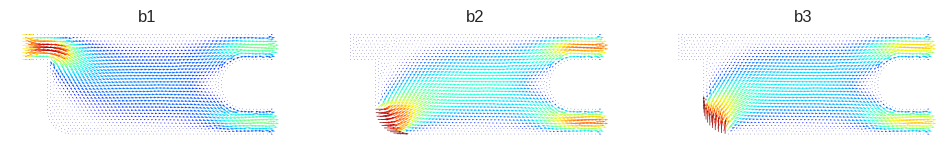

In [ ]:
plt.figure(figsize=(12, 2))
plt.subplot(131),fe.plot(b1f), plt.title("b1")
plt.subplot(132),fe.plot(b2f), plt.title("b2")
plt.subplot(133),fe.plot(b3f), plt.title("b3")
# plt.savefig("Velocity vector.png",dpi=600,bbox_inches="tight")  # Saves as PNG
plt.show()


### ***side note***: a look at initial condition

[0. 0. 0. ... 0. 0. 1.]


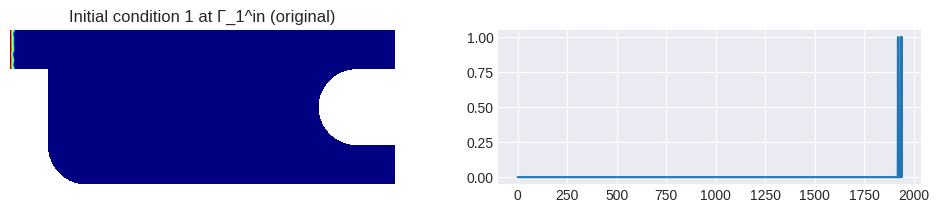

In [ ]:
u0f = fe.interpolate(lambda x:   (x[0] < 1e-16)  , Vh)
u0 = fe.dofs(u0f)
u_init = fe.asfunction(u0, Vh)
plt.figure(figsize=(12, 2))
plt.subplot(121)
fe.plot(u_init)

plt.title(f"Initial condition 1 at Γ_1^in (original)")
print(u0)
plt.subplot(122)
plt.plot(u0)

At the exact moment the simulation starts, we have a 100% concentration of the chemical (u=1) located only at the top inflow gate. The rest of the tank is empty (u=0). This models the scenario where a "slug" of the chemical is introduced instantaneously at the inlet, ready to be transported into the dispenser by the fluid flow.

[-1. -1. -1. ... -1. -1.  0.]


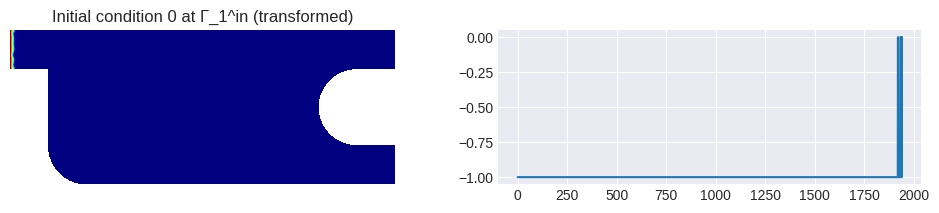

In [ ]:
u0f = fe.interpolate(lambda x:   (x[0] < 1e-16) - 1  , Vh)
u0 = fe.dofs(u0f)
u_init = fe.asfunction(u0, Vh)
plt.figure(figsize=(12, 2))
plt.subplot(121)
fe.plot(u_init)

plt.title(f"Initial condition 0 at Γ_1^in (transformed)")
print(u0)
plt.subplot(122)
plt.plot(u0)

this (x[0] < 1e-16) indicate the Γ^in

Case 1: At the top inflow gate (x ∈ Γ^in)
1_{Γ^in} is 1.
So, u_hom(·, 0) = 1 - 1 = 0.

Case 2: Everywhere else (x ∉ Γ^in)
1_{Γ^in} is 0.
So, u_hom(·, 0) = 0 - 1 = -1.

So, the transformed initial condition is a function that is 0 at the inlet and -1 everywhere else. A value of -1 has no physical meaning for concentration, u_hom is a mathematical tool. We recover the physical solution at the end by computing u = u_hom + 1.

## **Online Stage**

FOM evaluation time: 13912.48 milliseconds.
RB evaluation time: 86.18 milliseconds.

>> Boost: x161.


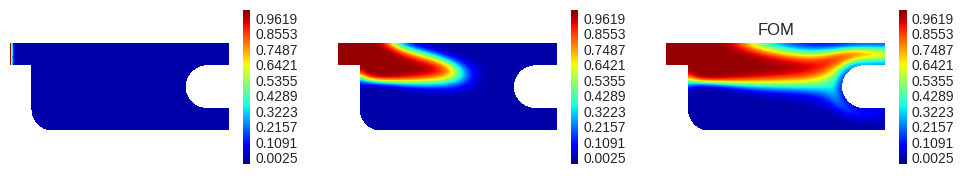

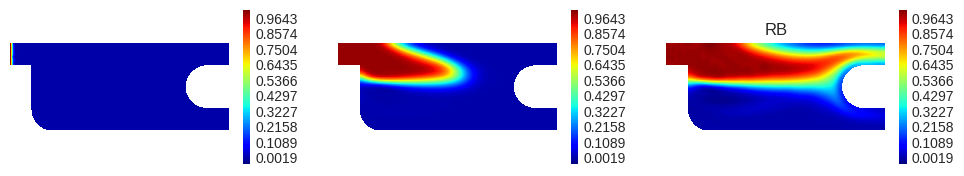

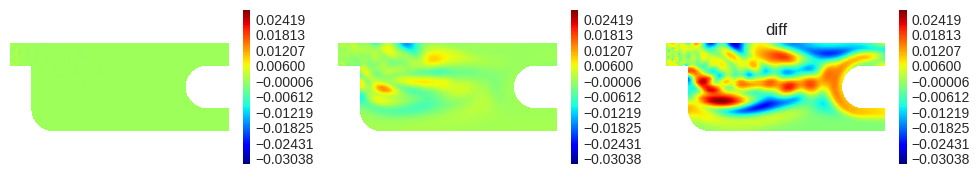

Bottom Outflow FOM: 0.02719585382836203
Bottom Outflow FOM: 0.025095770808909408
error for Bottom Outflow: 7.72%


In [ ]:
# Verification case
c1, c2, c3 = 50, 50*np.cos(0.57), 50*np.sin(0.57)
c1, c2, c3 = 40, 0, 50
t0 = perf_counter()
uFOM = FOMsolver(c1, c2, c3)
t1 = perf_counter()
dtFOM = t1-t0
t0 = perf_counter()
uRB = RBsolver(c1, c2, c3)
t1 = perf_counter()
dtROM = t1-t0

print("FOM evaluation time: %.2f milliseconds." % (1000*(dtFOM)))
print("RB evaluation time: %.2f milliseconds." % (1000*(t1-t0)))
print("\n>> Boost: x%d." % (dtFOM//dtROM))

# Visualization
fe.multiplot(uFOM[[1, 350, 700]],  (1, 3), Vh, vmin = uFOM.min(), vmax = uFOM.max(), colorbar=True,shrink=0.5)
plt.title('FOM')
plt.savefig("Visualization_FOM.png",dpi=600,bbox_inches="tight")  # Saves as PNG
fe.multiplot(uRB[[1, 350, 700]],  (1, 3), Vh, vmin = uRB.min(), vmax = uRB.max(), colorbar=True,shrink=0.5)
plt.title('RB')
plt.savefig("Visualization_RB.png",dpi=600,bbox_inches="tight")  # Saves as PNG
diff = uFOM - uRB
fe.multiplot(diff[[1, 350, 700]],  (1, 3), Vh, vmin = diff.min(), vmax = diff.max(), colorbar=True,shrink=0.5)
plt.title('diff')

plt.savefig("Visualization_diff.png",dpi=600,bbox_inches="tight")  # Saves as PNG
plt.show()

# Animation
FOManimation, RBanimation = False, False
if FOManimation == True:
  fe.animate(uFOM, Vh, figsize = (5, 2))
if RBanimation == True:
  fe.animate(uRB, Vh, figsize = (5, 2))

# Bottom Outflow Compare
print(f"Bottom Outflow FOM: {bottomOutflow(uFOM)}")
print(f"Bottom Outflow FOM: {bottomOutflow(uRB)}")
print(f"error for Bottom Outflow: {num2p(abs((bottomOutflow(uFOM)-bottomOutflow(uRB))/bottomOutflow(uFOM)))}")


Meaning: While the overall solution field (as seen in the diff plot) is very accurate (with pointwise errors being small), the error in this specific integrated quantity is more significant. POD is optimized to capture the global, energy-dominant features of the solution, not necessarily to be accurate for every possible local or integrated measurement.
This is not a mistake in code; it is a fundamental property of the standard POD-Galerkin method.

# **Part 4: Detailed Error Analysis (Task iii)**

$$
[\
error = \frac{ |u_{FOM} - u_{RB}|  } { |u_{FOM}| }
]\
$$

How well can chosen POD basis V represent the true FOM solution

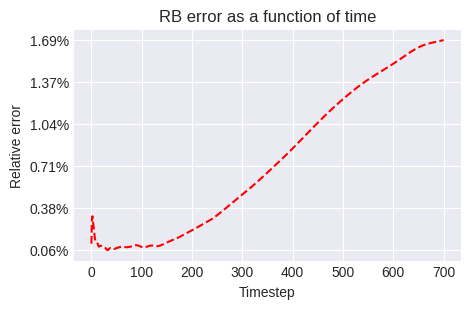

In [ ]:
# Relative error
errors = np.linalg.norm(uFOM-uRB, axis = 1)/np.linalg.norm(uFOM, axis = 1)
plt.figure(figsize = (5, 3))
plt.plot(errors, '--r')
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB error as a function of time")
# yticks = np.linspace(0, 0.015, 5)
# plt.yticks(yticks, [num2p(tick) for tick in yticks])

marks = np.linspace(errors.min(), errors.max(), 6)
# marks = [round(mark, 2) for mark in marks]
plt.yticks(marks, [num2p(mark).replace(".00", "") for mark in marks])

plt.savefig("Relative error.png",dpi=600,bbox_inches="tight")  # Saves as PNG
plt.show()


Error Growth Over Time: The plot shows the relative error starting near zero and growing. This is typical. The initial condition is projected with some error, and this error is then amplified by the model's dynamics over time. A slight mismatch in the eigenvalues of the ROM system matrix versus the FOM can lead to this behavior.

In [ ]:
utest = u[ntrain:] # use the test part of the u in RB
uRBtest = [RBsolver(m[0],m[1],m[2])-1 for m in mu[ntrain:]]
uRBtest = np.stack(uRBtest)
errors = np.linalg.norm(utest-uRBtest, axis = -1)/np.linalg.norm(utest, axis = -1)
etest = errors.max(axis = -1).mean()
print("Average uniform relative error: %s." % num2p(etest))

l2REs = []
for j in range(len(utest)):
  diff = utest[j] - uRBtest[j]
  l2diff = np.sqrt(np.diag(diff @ M @ diff.T))
  l2norm = np.sqrt(np.diag(utest[j] @ M @ utest[j].T))
  l2REs.append(l2diff/l2norm)
l2REs = np.stack(l2REs)
etestl2 = l2REs.max(axis = -1).mean()
print("Average uniform relative L2 error: %s." % num2p(etestl2))



Average uniform relative error: 0.92%.
Average uniform relative L2 error: 0.92%.


**Galerkin Projection of Operators**: When you create Mrb = V.T @ M @ V, you are assuming that the behavior of the mass matrix M can be perfectly described within the subspace spanned by V. The same is true for S and the B matrices. This is an approximation. The dynamics governed by the projected operators Mrb, Srb, Brb are not identical to the projection of the true dynamics.

**Accumulation in Time**: At each time step, the RBsolver makes a tiny prediction error. This error from step n becomes part of the input for step n+1. Over 700 time steps, these small errors accumulate, causing the final uRBtest trajectory to drift away from the true utest trajectory. The projection error, by contrast, is calculated independently at each time step without this memory of past errors.

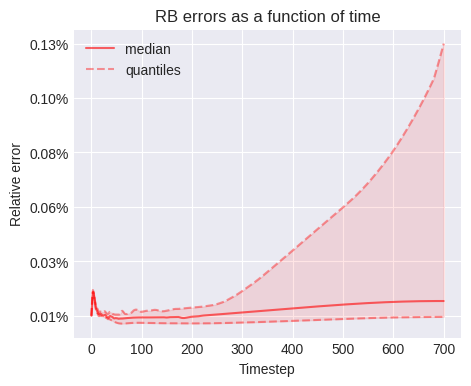

In [ ]:
# Relative error with quantiles
median = np.quantile(errors, 0.5, axis = 0)
q1 = np.quantile(errors, 0.25, axis = 0)
q3 = np.quantile(errors, 0.75, axis = 0)

plt.figure(figsize = (5, 4))
plt.plot(median, '-r', label = 'median', alpha = 0.6)
plt.plot(q1, '--r', label = 'quantiles', alpha = 0.4)
plt.plot(q3, '--r', alpha = 0.4)
plt.fill_between(np.arange(len(q1)), q1, q3, color = 'red', alpha = 0.1)
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB errors as a function of time")
# yticks = np.linspace(0, 0.0005, 3)
# plt.yticks(yticks, [num2p(tick) for tick in yticks])
marks = np.linspace(q3.min(), q3.max(), 6)
# marks = [round(mark, 2) for mark in marks]
plt.yticks(marks, [num2p(mark).replace(".00", "") for mark in marks])
plt.legend()

plt.savefig("Relative error with quantiles.png",dpi=600,bbox_inches="tight")  # Saves as PNG
plt.show()


Robustness (Quantile Plot): The tight band between the 25th and 75th quantiles indicates that the ROM performs consistently well across all the different parameter samples in test set. There are no "bad" parameter choices where the ROM suddenly fails. This means the model is robust within its training domain.

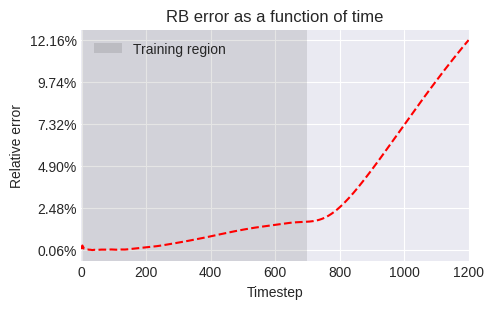

In [ ]:
# Extrapolation Error (steps)
steps = 1200
uFOMex = FOMsolver(c1,c2,c3, steps = steps)
uRBex = RBsolver(c1,c2,c3, steps = steps)
errors = np.linalg.norm(uFOMex-uRBex, axis = 1)/np.linalg.norm(uFOMex, axis = 1)
plt.figure(figsize = (5, 3))
plt.plot(errors, '--r')
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB error as a function of time")
marks = np.linspace(errors.min(), errors.max(), 6)
# marks = [round(mark, 2) for mark in marks]
plt.yticks(marks, [num2p(mark).replace(".00", "") for mark in marks])
ylim = plt.gca().get_ylim()
plt.fill([0, 700, 700, 0], [ylim[0], ylim[0], ylim[1], ylim[1]], 'k', label = "Training region", alpha = 0.1)
plt.axis([-1, steps+1, *ylim])
plt.legend()

plt.savefig("Extrapolation Error (steps).png",dpi=600,bbox_inches="tight")  # Saves as PNG
plt.show()


Extrapolation Failure: The plots are textbook examples of why you cannot trust a ROM outside the parameter/time domain it was trained on. The basis V does not contain the necessary "information" to represent these unseen dynamics, and the error blows up.

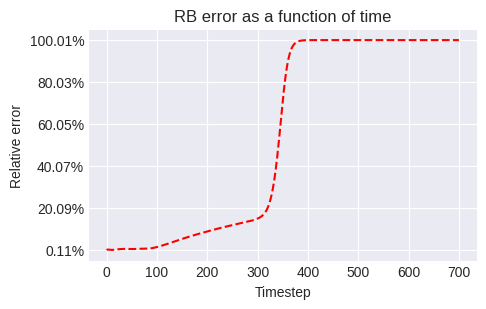

In [ ]:
# Extrapolation Error (mu)
muex = np.array([60, 60, 60])
uFOMex = FOMsolver(muex[0],muex[1],muex[2],steps=700)
uRBex = RBsolver(muex[0],muex[1],muex[2],steps=700)
errors = np.linalg.norm(uFOMex-uRBex, axis = 1)/np.linalg.norm(uFOMex, axis = 1)
plt.figure(figsize = (5, 3))
plt.plot(errors, '--r')
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB error as a function of time")
# yticks = np.linspace(0, 0.005, 3)
# plt.yticks(yticks, [num2p(tick) for tick in yticks])

marks = np.linspace(errors.min(), errors.max(), 6)
# marks = [round(mark, 2) for mark in marks]
plt.yticks(marks, [num2p(mark).replace(".00", "") for mark in marks])

plt.savefig("Extrapolation Error (mu).png",dpi=600,bbox_inches="tight")  # Saves as PNG
plt.show()


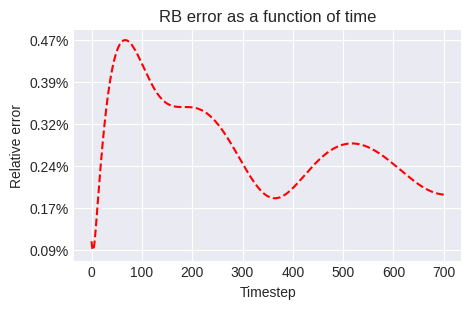

In [ ]:
# Extrapolation Error (dt)
uFOMex = FOMsolver(c1,c2,c3, steps = 700, dt = 1e-5)
uRBex = RBsolver(c1,c2,c3, steps = 700, dt = 1e-5)

errors = np.linalg.norm(uFOMex-uRBex, axis = 1)/np.linalg.norm(uFOMex, axis = 1)
plt.figure(figsize = (5, 3))
plt.plot(errors, '--r')
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB error as a function of time")
# yticks = np.linspace(0, 0.007, 3)
# plt.yticks(yticks, [num2p(tick) for tick in yticks])
marks = np.linspace(errors.min(), errors.max(), 6)
# marks = [round(mark, 2) for mark in marks]
plt.yticks(marks, [num2p(mark).replace(".00", "") for mark in marks])

plt.savefig("Extrapolation Error (dt).png",dpi=600,bbox_inches="tight")  # Saves as PNG
plt.show()


# **Part 5: Parameter Optimization (Task iv)**

### ***side note***: a look at bottom_out and verify visually

(<Axes: >, [<matplotlib.lines.Line2D at 0x79e2b22a27d0>])

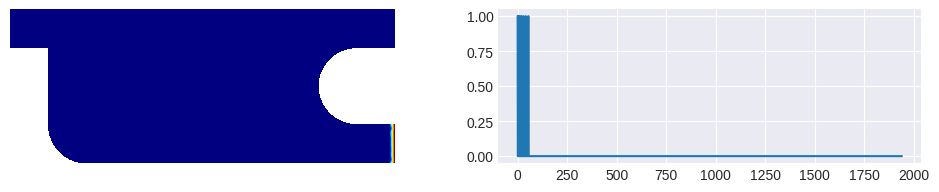

In [ ]:
bottom_out = fe.dofs(fe.interpolate(lambda x: (10-x[0]<1e-12)*(x[1]<-2), Vh))
bottom_out0 = fe.asfunction(bottom_out, Vh)
plt.figure(figsize=(12, 2))
plt.subplot(121), fe.plot(bottom_out0)
plt.subplot(122), plt.plot(bottom_out) # bottomout is = 1 only at Ndof at the exit

the function bottom_outflow calculates the line integral of the concentration at the final time step.

## RB plot

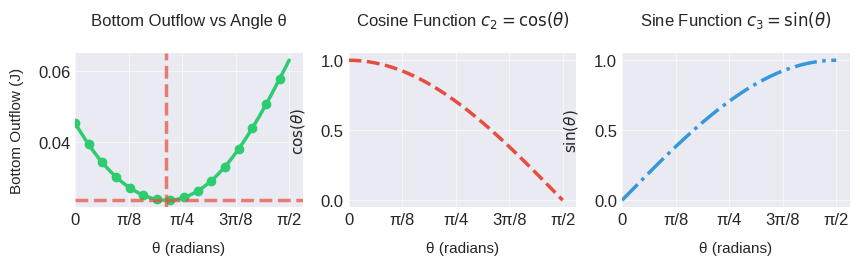

Bottom outflow at theta: 38.39° is minimum: 0.02362


In [ ]:
# Parameter optimization visualization
theta = np.arange(0, np.pi/2, 0.01)
J = [bottomOutflow(RBsolver(50, 50*np.cos(t), 50*np.sin(t))) for t in theta]
theta_min = theta[np.argmin(J)]
J_min = J[np.argmin(J)]

# Set style and figure parameters
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (6, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['lines.linewidth'] = 2.5

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 2))

# First plot: Bottom outflow
axes[0].plot(theta, J, color='#2ecc71', marker='o', markersize=6, markevery=10)
axes[0].axvline(theta_min, color='#e74c3c', linestyle='--', alpha=0.7, label=f'Min at θ={theta_min:.2f}')
axes[0].axhline(J_min, color='#e74c3c', linestyle='--', alpha=0.7)
axes[0].set_title('Bottom Outflow vs Angle θ', pad=20)
axes[0].set_xlabel('θ (radians)', labelpad=10)
axes[0].set_ylabel('Bottom Outflow (J)', labelpad=10)
axes[0].grid(True, alpha=0.6)
axes[0].set_xlim(0, np.pi/2+0.1)
axes[0].set_xticks(np.arange(0, np.pi/2+0.1, np.pi/8))
axes[0].set_xticklabels(['0', 'π/8', 'π/4', '3π/8', 'π/2'])

# Second plot: Cosine
axes[1].plot(theta, np.cos(theta), color='#e74c3c', linestyle='--')
axes[1].set_title(r'Cosine Function $c_2 = \cos(\theta)$', pad=20)
axes[1].set_xlabel('θ (radians)', labelpad=10)
axes[1].set_ylabel(r'$\cos(\theta)$', labelpad=10)
axes[1].grid(True, alpha=0.6)
axes[1].set_xlim(0, np.pi/2+0.1)
axes[1].set_xticks(np.arange(0, np.pi/2+0.1, np.pi/8))
axes[1].set_xticklabels(['0', 'π/8', 'π/4', '3π/8', 'π/2'])

# Third plot: Sine
axes[2].plot(theta, np.sin(theta), color='#3498db', linestyle='-.')
axes[2].set_title(r'Sine Function $c_3 = \sin(\theta)$', pad=20)
axes[2].set_xlabel('θ (radians)', labelpad=10)
axes[2].set_ylabel(r'$\sin(\theta)$', labelpad=10)
axes[2].grid(True, alpha=0.6)
axes[2].set_xlim(0, np.pi/2+0.1)
axes[2].set_xticks(np.arange(0, np.pi/2+0.1, np.pi/8))
axes[2].set_xticklabels(['0', 'π/8', 'π/4', '3π/8', 'π/2'])

# Adjust layout and spacing
# plt.tight_layout(pad=4.0)
plt.savefig("Bottom outflow optimization.png",dpi=600,bbox_inches="tight")  # Saves as PNG
plt.show()
print("Bottom outflow at theta: %.2f° is minimum: %.5f" % (theta_min*180/np.pi, J_min))

In [ ]:
bottomOutflow(uFOM)

np.float64(0.02719585382836203)

## FOM plot

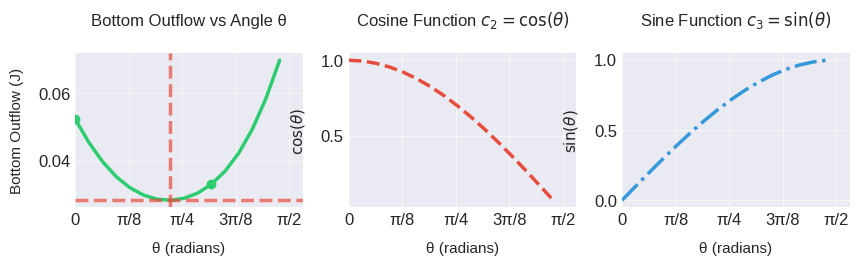

Bottom outflow at theta: 40.11° is minimum: 0.02831


In [ ]:
# Parameter optimization visualization
theta = np.arange(0, np.pi/2, 0.1)
J = [bottomOutflow(FOMsolver(50, 50*np.cos(t), 50*np.sin(t))) for t in theta]
theta_min = theta[np.argmin(J)]
J_min = J[np.argmin(J)]

# Set style and figure parameters
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (6, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['lines.linewidth'] = 2.5

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 2))

# First plot: Bottom outflow
axes[0].plot(theta, J, color='#2ecc71', marker='o', markersize=6, markevery=10)
axes[0].axvline(theta_min, color='#e74c3c', linestyle='--', alpha=0.7, label=f'Min at θ={theta_min:.2f}')
axes[0].axhline(J_min, color='#e74c3c', linestyle='--', alpha=0.7)
axes[0].set_title('Bottom Outflow vs Angle θ', pad=20)
axes[0].set_xlabel('θ (radians)', labelpad=10)
axes[0].set_ylabel('Bottom Outflow (J)', labelpad=10)
axes[0].grid(True, alpha=0.6)
axes[0].set_xlim(0, np.pi/2+0.1)
axes[0].set_xticks(np.arange(0, np.pi/2+0.1, np.pi/8))
axes[0].set_xticklabels(['0', 'π/8', 'π/4', '3π/8', 'π/2'])

# Second plot: Cosine
axes[1].plot(theta, np.cos(theta), color='#e74c3c', linestyle='--')
axes[1].set_title(r'Cosine Function $c_2 = \cos(\theta)$', pad=20)
axes[1].set_xlabel('θ (radians)', labelpad=10)
axes[1].set_ylabel(r'$\cos(\theta)$', labelpad=10)
axes[1].grid(True, alpha=0.6)
axes[1].set_xlim(0, np.pi/2+0.1)
axes[1].set_xticks(np.arange(0, np.pi/2+0.1, np.pi/8))
axes[1].set_xticklabels(['0', 'π/8', 'π/4', '3π/8', 'π/2'])

# Third plot: Sine
axes[2].plot(theta, np.sin(theta), color='#3498db', linestyle='-.')
axes[2].set_title(r'Sine Function $c_3 = \sin(\theta)$', pad=20)
axes[2].set_xlabel('θ (radians)', labelpad=10)
axes[2].set_ylabel(r'$\sin(\theta)$', labelpad=10)
axes[2].grid(True, alpha=0.6)
axes[2].set_xlim(0, np.pi/2+0.1)
axes[2].set_xticks(np.arange(0, np.pi/2+0.1, np.pi/8))
axes[2].set_xticklabels(['0', 'π/8', 'π/4', '3π/8', 'π/2'])

# Adjust layout and spacing
# plt.tight_layout(pad=4.0)
plt.savefig("Bottom outflow optimization.png",dpi=600,bbox_inches="tight")  # Saves as PNG
plt.show()
print("Bottom outflow at theta: %.2f° is minimum: %.5f" % (theta_min*180/np.pi, J_min))

## RB and FOM comparison

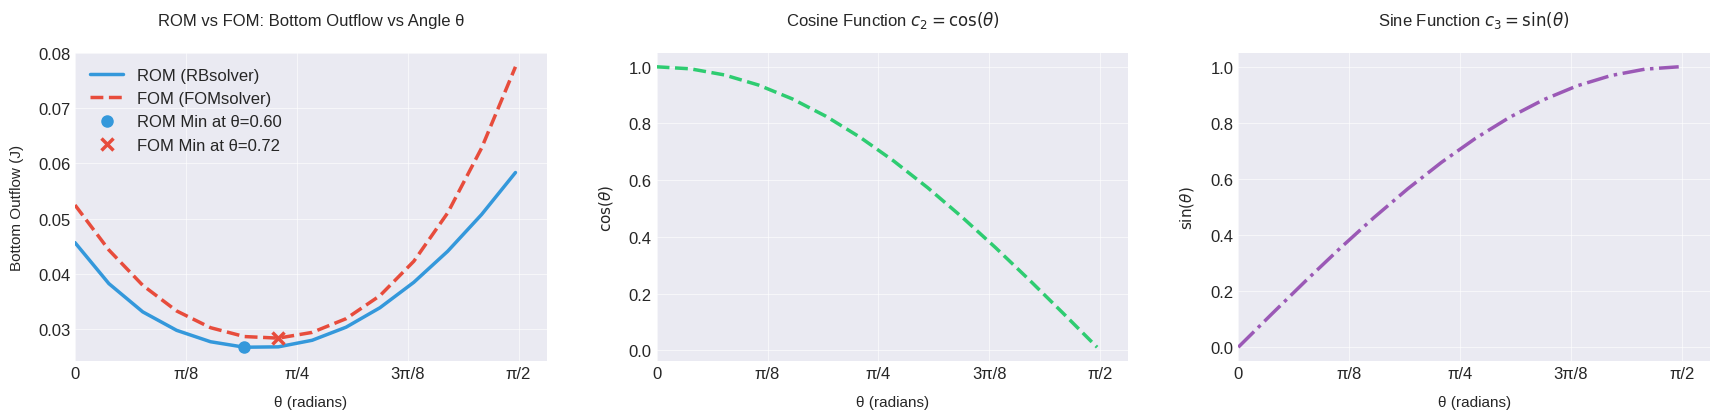

ROM: Bottom outflow at theta: 34.38° is minimum: 0.02670
FOM: Bottom outflow at theta: 41.25° is minimum: 0.02835


In [ ]:
# 1. Parameter and Data Calculation
# Use a single, finer theta grid for a smooth comparison
theta = np.arange(0, np.pi/2, 0.12)

# Calculate J for both ROM and FOM
J_rom = [bottomOutflow(RBsolver(50, 50*np.cos(t), 50*np.sin(t))) for t in theta]
J_fom = [bottomOutflow(FOMsolver(50, 50*np.cos(t), 50*np.sin(t))) for t in theta]

# Find the minimum for each model
theta_min_rom = theta[np.argmin(J_rom)]
J_min_rom = np.min(J_rom)

theta_min_fom = theta[np.argmin(J_fom)]
J_min_fom = np.min(J_fom)


# 2. Set style and figure parameters
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (6, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['lines.linewidth'] = 2.5

# 3. Create a figure with subplots
# Increased figsize width to better accommodate the legend
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- First plot: Combined Bottom Outflow for ROM and FOM ---
axes[0].plot(theta, J_rom, color='#3498db', linestyle='-', label='ROM (RBsolver)')
axes[0].plot(theta, J_fom, color='#e74c3c', linestyle='--', label='FOM (FOMsolver)')

# Add markers for the minimum points
axes[0].plot(theta_min_rom, J_min_rom, 'o', color='#3498db', markersize=8, label=f'ROM Min at θ={theta_min_rom:.2f}')
axes[0].plot(theta_min_fom, J_min_fom, 'x', color='#e74c3c', markersize=8, markeredgewidth=2.5, label=f'FOM Min at θ={theta_min_fom:.2f}')

axes[0].set_title('ROM vs FOM: Bottom Outflow vs Angle θ', pad=20)
axes[0].set_xlabel('θ (radians)', labelpad=10)
axes[0].set_ylabel('Bottom Outflow (J)', labelpad=10)
axes[0].grid(True, alpha=0.6)
axes[0].legend() # Display the labels for each line
axes[0].set_xlim(0, np.pi/2+0.1)
axes[0].set_xticks(np.arange(0, np.pi/2+0.1, np.pi/8))
axes[0].set_xticklabels(['0', 'π/8', 'π/4', '3π/8', 'π/2'])


# --- Second plot: Cosine ---
axes[1].plot(theta, np.cos(theta), color='#2ecc71', linestyle='--')
axes[1].set_title(r'Cosine Function $c_2 = \cos(\theta)$', pad=20)
axes[1].set_xlabel('θ (radians)', labelpad=10)
axes[1].set_ylabel(r'$\cos(\theta)$', labelpad=10)
axes[1].grid(True, alpha=0.6)
axes[1].set_xlim(0, np.pi/2+0.1)
axes[1].set_xticks(np.arange(0, np.pi/2+0.1, np.pi/8))
axes[1].set_xticklabels(['0', 'π/8', 'π/4', '3π/8', 'π/2'])


# --- Third plot: Sine ---
axes[2].plot(theta, np.sin(theta), color='#9b59b6', linestyle='-.')
axes[2].set_title(r'Sine Function $c_3 = \sin(\theta)$', pad=20)
axes[2].set_xlabel('θ (radians)', labelpad=10)
axes[2].set_ylabel(r'$\sin(\theta)$', labelpad=10)
axes[2].grid(True, alpha=0.6)
axes[2].set_xlim(0, np.pi/2+0.1)
axes[2].set_xticks(np.arange(0, np.pi/2+0.1, np.pi/8))
axes[2].set_xticklabels(['0', 'π/8', 'π/4', '3π/8', 'π/2'])

# Adjust layout and spacing
plt.tight_layout(pad=3.0)
plt.savefig("ROM_vs_FOM_optimization.png", dpi=600, bbox_inches="tight")  # Updated filename
plt.show()

# Print the results for both models
print("ROM: Bottom outflow at theta: %.2f° is minimum: %.5f" % (theta_min_rom*180/np.pi, J_min_rom))
print("FOM: Bottom outflow at theta: %.2f° is minimum: %.5f" % (theta_min_fom*180/np.pi, J_min_fom))

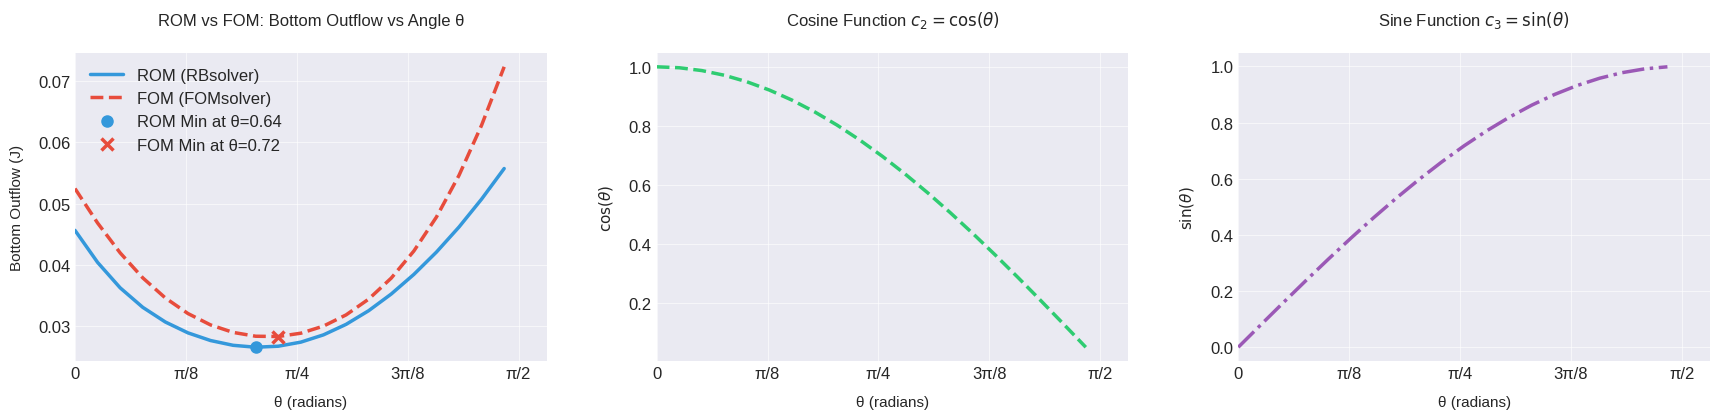

ROM: Bottom outflow at theta: 36.67° is minimum: 0.02660
FOM: Bottom outflow at theta: 41.25° is minimum: 0.02835


In [ ]:
# 1. Parameter and Data Calculation
# Use a single, finer theta grid for a smooth comparison
theta = np.arange(0, np.pi/2, 0.08)

# Calculate J for both ROM and FOM
J_rom = [bottomOutflow(RBsolver(50, 50*np.cos(t), 50*np.sin(t))) for t in theta]
J_fom = [bottomOutflow(FOMsolver(50, 50*np.cos(t), 50*np.sin(t))) for t in theta]

# Find the minimum for each model
theta_min_rom = theta[np.argmin(J_rom)]
J_min_rom = np.min(J_rom)

theta_min_fom = theta[np.argmin(J_fom)]
J_min_fom = np.min(J_fom)


# 2. Set style and figure parameters
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (6, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['lines.linewidth'] = 2.5

# 3. Create a figure with subplots
# Increased figsize width to better accommodate the legend
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- First plot: Combined Bottom Outflow for ROM and FOM ---
axes[0].plot(theta, J_rom, color='#3498db', linestyle='-', label='ROM (RBsolver)')
axes[0].plot(theta, J_fom, color='#e74c3c', linestyle='--', label='FOM (FOMsolver)')

# Add markers for the minimum points
axes[0].plot(theta_min_rom, J_min_rom, 'o', color='#3498db', markersize=8, label=f'ROM Min at θ={theta_min_rom:.2f}')
axes[0].plot(theta_min_fom, J_min_fom, 'x', color='#e74c3c', markersize=8, markeredgewidth=2.5, label=f'FOM Min at θ={theta_min_fom:.2f}')

axes[0].set_title('ROM vs FOM: Bottom Outflow vs Angle θ', pad=20)
axes[0].set_xlabel('θ (radians)', labelpad=10)
axes[0].set_ylabel('Bottom Outflow (J)', labelpad=10)
axes[0].grid(True, alpha=0.6)
axes[0].legend() # Display the labels for each line
axes[0].set_xlim(0, np.pi/2+0.1)
axes[0].set_xticks(np.arange(0, np.pi/2+0.1, np.pi/8))
axes[0].set_xticklabels(['0', 'π/8', 'π/4', '3π/8', 'π/2'])


# --- Second plot: Cosine ---
axes[1].plot(theta, np.cos(theta), color='#2ecc71', linestyle='--')
axes[1].set_title(r'Cosine Function $c_2 = \cos(\theta)$', pad=20)
axes[1].set_xlabel('θ (radians)', labelpad=10)
axes[1].set_ylabel(r'$\cos(\theta)$', labelpad=10)
axes[1].grid(True, alpha=0.6)
axes[1].set_xlim(0, np.pi/2+0.1)
axes[1].set_xticks(np.arange(0, np.pi/2+0.1, np.pi/8))
axes[1].set_xticklabels(['0', 'π/8', 'π/4', '3π/8', 'π/2'])


# --- Third plot: Sine ---
axes[2].plot(theta, np.sin(theta), color='#9b59b6', linestyle='-.')
axes[2].set_title(r'Sine Function $c_3 = \sin(\theta)$', pad=20)
axes[2].set_xlabel('θ (radians)', labelpad=10)
axes[2].set_ylabel(r'$\sin(\theta)$', labelpad=10)
axes[2].grid(True, alpha=0.6)
axes[2].set_xlim(0, np.pi/2+0.1)
axes[2].set_xticks(np.arange(0, np.pi/2+0.1, np.pi/8))
axes[2].set_xticklabels(['0', 'π/8', 'π/4', '3π/8', 'π/2'])

# Adjust layout and spacing
plt.tight_layout(pad=3.0)
plt.savefig("ROM_vs_FOM_optimization.png", dpi=600, bbox_inches="tight")  # Updated filename
plt.show()

# Print the results for both models
print("ROM: Bottom outflow at theta: %.2f° is minimum: %.5f" % (theta_min_rom*180/np.pi, J_min_rom))
print("FOM: Bottom outflow at theta: %.2f° is minimum: %.5f" % (theta_min_fom*180/np.pi, J_min_fom))